In [1]:
%matplotlib inline 
#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import random            as random
import numpy             as np
import pandas            as pd
#import tables            as tb
import matplotlib.pyplot as plt
import os 

In [5]:
import xyimg.dataprep as dp
import xyimg.cnn      as cnn

## Definitions

In [20]:
path = os.environ['LPRDATADIR']

pressure  = '5bar'

root  = path+'/cvoxels/'+pressure+'_bunch*.h5'
label = 'xy_segclass_max', 'yz_segclass_max', 'zx_segclass_max'
width = 10
frame = 150

evtdis  = dp.EvtDispatch(root)
imgdis  = dp.ImgDispatch(evtdis, label, width, frame)
imgset = cnn.ImgDataset(imgdis)

number of files  54


target  0


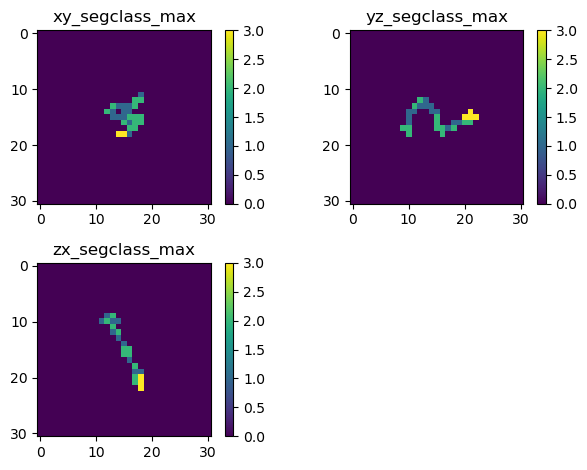

In [12]:
nevts = len(imgdis)
index = random.choice(range(nevts))
x, y = imgdis[index]
dp.plot_img(x, y, label)

In [14]:
xb = np.array([imgdis[i][0] for i in range(1000)])

## RUN CNN

In [19]:
x, _            = imgdis[0]
depth, width, _ = x.shape
print('Img shape ', x.shape)
expansion =   4
nepochs   =   4
kernel    =   3
kcnn  = cnn.HCNN(depth, width, expansion = expansion, kernel = kernel)

Img shape  (3, 31, 31)
int conv : width =  31
1st conv : width =  31 , kernel =  15
2nd conv : width =  19 , kernel =  9
3rd conv : width =  13 , kernel =  6
4th conv : width =  10 , kernel =  5
out conv : width =  8


In [23]:
cnn_name = 'test_hcnn'
ofile    = 'test.npz'
print(ofile)
config = cnn.config
config['loss_function'] = 'CrossEntropyLoss'
config['learning_rate'] = 0.001
box  = cnn.run(imgset, kcnn, ofilename = ofile, nepochs = nepochs, config = config)

test.npz
{'loss_function': 'CrossEntropyLoss', 'learning_rate': 0.001}
Event Image sample :  torch.Size([3, 31, 31])
Using cpu device 
HCNN(
  (conv1): Conv2d(3, 12, kernel_size=(15, 15), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 24, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(24, 48, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(48, 96, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=6144, out_features=2, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
)
Is CUDA avialable? False 
input data shape =>torch.Size([100, 3, 31, 31])
conv 1 =>torch.S

In [ ]:
cnn.prod()

In [24]:
box = np.load(ofile)

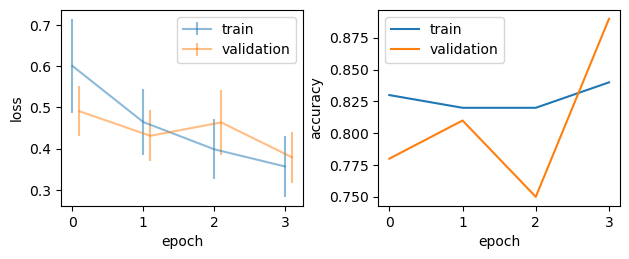

In [25]:
cnn.plot_epochs(box['losses'], box['accuracies'])

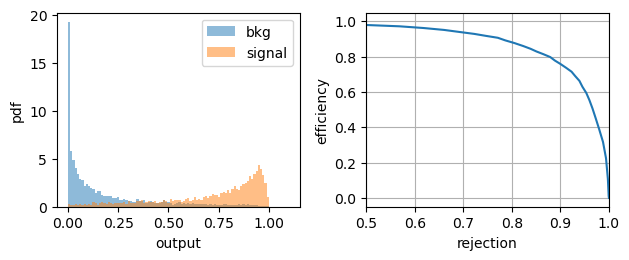

In [26]:
cnn.plot_roc(box['y'], box['yp'])

## Ana CNN